<b>루브릭</b> <br>


|평가문항|상세기준|
|:---|:---|
|1. 한글코퍼스를 가공하여 BERT pretrain용 데이터셋을 잘 생상하였다.|MLM, NSP task 특징이 잘 반영된 pretrain용 데이터셋 생성과정이 체계적으로 진행되었다.|
|2. 구현한 BERT 모델의 학습이 안정적으로 진행됨을 확인하였다.| 학습진행 과정 중에서 MLM, NSP loss의 안정적인 감소가 확인되었다.|
|3. 1M자리 mini BERT 모델의 제작과 학습이 정상적으로 진행되었다.|학습된 모델 및 학습과정의 시각화 내역이 제출되었다.|

In [2]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib
import json
import re

print(tf.__version__)
print(np.__version__)
print(pd.__version__)
print(matplotlib.__version__)
print(json.__version__)
print(re.__version__)

2.6.0
1.21.4
1.3.3
3.4.3
2.0.9
2.2.1


In [3]:
import os
import math
import random
import collections
import shutil
import zipfile
import copy
from datetime import datetime

import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm.notebook import tqdm

import tensorflow.keras.backend as K

random_seed  = 1234
random.seed(random_seed)
np.random.seed(random_seed)

### 1. Tokenizer 준비

SentencePiece 모델을 이용해 BERT의 MLM 학습용 데이터를 만드세요. <br>

이를 위해 한글 나무 위키 코퍼스로부터 8000의 vocab_size를 갖는 sentencepiece 모델을 만들어 보세요. BERT에 사용되는 주요 특수문자가 vocab에 포함되어야 합니다. (시간이 부족하다면 클라우드에 저장된 sentencepiece 모델을 사용하세요.)

In [2]:
corpus_file = os.getenv('HOME') + '/aiffel/bert_pretrain/data/kowiki.txt'
prefix = 'ko_8000'
vocab_size = 8000

spm.SentencePieceTrainer.train(
    f"--input={corpus_file} --model_prefix={prefix} --vocab_size={vocab_size + 7}" + 
    " --model_type=bpe" +
    " --max_sentence_length=999999" + # 문장 최대 길이
    " --pad_id=0 --pad_piece=[PAD]" + # pad (0)
    " --unk_id=1 --unk_piece=[UNK]" + # unknown (1)
    " --bos_id=2 --bos_piece=[BOS]" + # begin of sequence (2)
    " --eos_id=3 --eos_piece=[EOS]" + # end of sequence (3)
    " --user_defined_symbols=[SEP],[CLS],[MASK]") # 사용자 정의 토큰

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/bert_pretrain/data/kowiki.txt --model_prefix=ko_8000 --vocab_size=8007 --model_type=bpe --max_sentence_length=999999 --pad_id=0 --pad_piece=[PAD] --unk_id=1 --unk_piece=[UNK] --bos_id=2 --bos_piece=[BOS] --eos_id=3 --eos_piece=[EOS] --user_defined_symbols=[SEP],[CLS],[MASK]
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/bert_pretrain/data/kowiki.txt
  input_format: 
  model_prefix: ko_8000
  model_type: BPE
  vocab_size: 8007
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 999999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  us

In [3]:
vocab = spm.SentencePieceProcessor()
vocab.load(f'./{prefix}.model')

True

In [4]:
vocab_list = []
for id in range(7, len(vocab)):
    if not vocab.is_unknown(id):
        vocab_list.append(vocab.id_to_piece(id))

len(vocab_list)

8000

In [5]:
string_a = "추적추적 비가 내리는 날이었어 그날은 왠지 손님이 많아 첫 번에 삼십 전 둘째번 오십 전 오랜만에 받아보는 십 전짜리 백통화 서푼에"
string_b = "손바닥 위엔 기쁨의 눈물이 흘러 컬컬한 목에 모주 한잔을 적셔 몇 달 포 전부터 콜록거리는 아내 생각에 그토록 먹고 싶다던"

tokens_org = ["[CLS]"] + vocab.encode_as_pieces(string_a) + ["[SEP]"] + vocab.encode_as_pieces(string_b) + ["[SEP]"]

print(tokens_org)

['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]']


### 2. 데이터 전처리 (1) MASK 생성

BERT의 MLM에 필요한 빈칸(mask)을 학습 데이터 전체 토큰의 15% 정도로 만들어 주세요. 그 중 80%는 [MASK] 토큰, 10%는 랜덤한 토큰, 나머지 10%는 원래의 토큰을 그대로 사용하세요.

In [6]:
mask_cnt = int((len(tokens_org) - 3) * 0.15)

mask_cnt

14

In [7]:
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    마스크 생성
    :param tokens: tokens
    :param mask_cnt: mask 개수 (전체 tokens의 15%)
    :param vocab_list: vocab list (random token 용)
    :return tokens: mask된 tokens
    :return mask_idx: mask된 token의 index
    :return mask_label: mask된 token의 원래 값
    """
    cand_idx = []  
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])

    random.shuffle(cand_idx)

    mask_lms = [] 
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:  
            break
        if len(mask_lms) + len(index_set) > mask_cnt:  
            continue
        dice = random.random()  
        for index in index_set:
            masked_token = None
            if dice < 0.8:  
                masked_token = "[MASK]"
            elif dice < 0.9: 
                masked_token = tokens[index]
            else:  
                masked_token = random.choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token

    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]  
    mask_label = [p["label"] for p in mask_lms] 

    return tokens, mask_idx, mask_label

In [8]:
tokens = copy.deepcopy(tokens_org)
tokens, mask_idx, mask_label = create_pretrain_mask(tokens, mask_cnt, vocab_list)

In [9]:
print(tokens_org)

['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]']


In [10]:
print(tokens)

['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '[MASK]', '[MASK]', '[MASK]', '▁삼', '십', '▁전', '▁둘', '째', '번', '[MASK]', '[MASK]', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '프', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '[MASK]', '[MASK]', '[MASK]', '▁눈', '물이', '▁흘', '러', '[MASK]', '[MASK]', '[MASK]', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]']


In [11]:
print("mask_idx   :", mask_idx)
print("mask_label :", mask_label)

mask_idx   : [23, 24, 25, 32, 33, 41, 57, 58, 59, 64, 65, 66, 79, 80]
mask_label : ['▁첫', '▁번', '에', '▁오', '십', '▁십', '▁기', '쁨', '의', '▁컬', '컬', '한', '▁전', '부터']


### 3. 데이터 전처리 (2) NSP pair 생성

BERT의 pretrain task인 NSP는 두 문장이 연속하는지 확인하는 것입니다. 이를 위해 2개의 문장을 짝지어 50%의 확률로 TRUE와 FALSE를 지정해 주세요.

두 문장 사이에 segment 처리를 해주세요. 첫 번째 문장의 segment는 0, 두 번째 문장은 1로 채워준 후 둘 사이에 구분자인 [SEP] 등을 넣어주세요.

MLM과 NSP는 동시에 학습된다는 것을 염두에 두고 학습 데이터를 구성해 보세요.

In [12]:
string = """추적추적 비가 내리는 날이었어
그날은 왠지 손님이 많아
첫 번에 삼십 전 둘째 번 오십 전
오랜만에 받아보는 십 전짜리 백통화 서푼에
손바닥 위엔 기쁨의 눈물이 흘러
컬컬한 목에 모주 한잔을 적셔
몇 달 포 전부터 콜록거리는 아내
생각에 그토록 먹고 싶다던
설렁탕 한 그릇을 이제는 살 수 있어
집으로 돌아가는 길 난 문득 떠올라
아내의 목소리가 거칠어만 가는 희박한 숨소리가
오늘은 왠지 나가지 말라던 내 옆에 있어 달라던
그리도 나가고 싶으면 일찍이라도 들어와 달라던
아내의 간절한 목소리가 들려와
나를 원망하듯 비는 점점 거세져
싸늘히 식어가는 아내가 떠올라 걱정은 더해져
난 몰라 오늘은 운수 좋은 날
난 맨날 이렇게 살 수 있으면 얼마나 좋을까"""

In [13]:
doc = [vocab.encode_as_pieces(line) for line in string.split("\n")]

doc[:5]

[['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어'],
 ['▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아'],
 ['▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전'],
 ['▁오',
  '랜',
  '만에',
  '▁받아',
  '보',
  '는',
  '▁십',
  '▁전',
  '짜',
  '리',
  '▁백',
  '통',
  '화',
  '▁서',
  '푼',
  '에'],
 ['▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러']]

In [14]:
def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    tokens_a, tokens_b의 길이를 줄임 최대 길이: max_seq
    :param tokens_a: tokens A
    :param tokens_b: tokens B
    :param max_seq: 두 tokens 길이의 최대 값
    """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break

        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

In [15]:
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    doc별 pretrain 데이터 생성
    """
    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):
        current_chunk.append(doc[i])
        current_length += len(doc[i])
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])

            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            if random.random() < 0.5:
                is_next = 0
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1

            trim_tokens(tokens_a, tokens_b, max_seq)
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)

            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)

            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)

            current_chunk = []
            current_length = 0
    return instances

In [16]:
n_test_seq = 64

instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)

In [17]:
for instance in instances:
    print(instance)

{'tokens': ['[CLS]', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '[MASK]', '[MASK]', '▁전', '▁둘', '째', '[MASK]', '▁오', '십', '[MASK]', '▁오', '랜', '만에', '▁받아', '보', '는', '[MASK]', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '[SEP]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '[MASK]', '[MASK]', '[MASK]', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'is_next': 0, 'mask_idx': [14, 15, 16, 19, 22, 29, 60, 61, 62], 'mask_label': ['▁삼', '십', '▁전', '▁번', '▁전', '▁십', '▁날', '이었', '어']}
{'tokens': ['[CLS]', '[MASK]', '[MASK]', '▁돌아', '가는', '▁길', '▁난', '▁문', '득', '▁떠', '올', '라', '▁아내', '의', '[MASK]', '[MASK]', '[MASK]', '▁거', '칠', '어', '만', '▁가는', '▁희', '박', '한', '▁숨', '소', '리가', '[SEP]', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', 

### 4. 데이터 전처리 (3) 데이터셋 완성

BERT pretrain 데이터셋을 생성해, json 포맷으로 저장하세요. 데이터셋의 사이즈가 크므로np.memmap을 사용해 메모리 사용량을 최소화해 보세요.

In [18]:
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """ pretrain 데이터 생성 """
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")


    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):
            vocab_list.append(vocab.id_to_piece(id))

    
    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "": 
                    if 0 < len(doc):
                        save_pretrain_instances(out_f, doc)
                        doc = []
                else:  
                    pieces = vocab.encode_as_pieces(line)
                    if 0 < len(pieces):
                        doc.append(pieces)
            if 0 < len(doc):  
                save_pretrain_instances(out_f, doc)
                doc = []

In [19]:
corpus_file = os.getenv('HOME') + '/aiffel/bert_pretrain/data/kowiki.txt'
pretrain_json_path = os.getenv('HOME') + '/aiffel/bert_pretrain/data/bert_pre_train.json'

make_pretrain_data(vocab, corpus_file, pretrain_json_path, 128)

  0%|          | 0/3957761 [00:00<?, ?it/s]

In [20]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    학습에 필요한 데이터를 로드
    :param vocab: vocab
    :param filename: 전처리된 json 파일
    :param n_seq: 시퀀스 길이 (number of sequence)
    :param count: 데이터 수 제한 (None이면 전체)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            # 데이터 수 제한
            if count is not None and count <= total:
                break
    
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            
            label_nsp = data["is_next"]
            
            mask_idx = np.array(data["mask_idx"], dtype=np.int)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
            label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

In [21]:
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128)

  0%|          | 0/918189 [00:00<?, ?it/s]

/tmp/ipykernel_131/1756625244.py:41: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_idx = np.array(data["mask_idx"], dtype=np.int)
/tmp/ipykernel_131/1756625244.py:42: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated

### 5. BERT 모델 구현

pad mask, ahead mask 함수, gelu activation 함수, parameter initializer 생성 함수, json을 config 형태로 사용하기 위한 유틸리티 함수를 먼저 만들어 두세요.

Embedding 레이어, Transformer encoder 레이어, BERT 레이어를 구성한 후, pretraine용 BERT 모델을 만들어 봅시다.

In [22]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask

In [23]:
def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask

In [24]:
@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5 * x * (1 + K.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))

In [25]:
def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)

In [26]:
def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer

In [27]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [28]:
class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """

        if mode == "embedding":
            return self._embedding(inputs)
        elif mode == "linear":
            return self._linear(inputs)
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])
        return outputs

In [29]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Positional Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(
            config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: positional embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

In [30]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [31]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        self.W_Q = tf.keras.layers.Dense(
            config.n_head * config.d_head, 
            kernel_initializer=kernel_initializer(), 
            bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(
            config.n_head * config.d_head, 
            kernel_initializer=kernel_initializer(), 
            bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(
            config.n_head * config.d_head, 
            kernel_initializer=kernel_initializer(), 
            bias_initializer=bias_initializer())
        
        self.attention = ScaleDotProductAttention(name="self_attention")
        
        self.W_O = tf.keras.layers.Dense(
            config.d_model, 
            kernel_initializer=kernel_initializer(), 
            bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)
        
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])
        attn_out = self.W_O(attn_out)

        return attn_out

In [32]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(
            config.d_ff, activation=gelu, 
            kernel_initializer=kernel_initializer(), 
            bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(
            config.d_model, 
            kernel_initializer=kernel_initializer(), 
            bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

In [33]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

In [34]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: (enc_tokens, segments)
        :return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        """
        enc_tokens, segments = inputs

        enc_self_mask = tf.keras.layers.Lambda(
            get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = self.embedding(enc_out, mode="linear")
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

In [35]:
class PooledOutput(tf.keras.layers.Layer):
    def __init__(self, config, n_output, name="pooled_output"):
        super().__init__(name=name)

        self.dense1 = tf.keras.layers.Dense(
            config.d_model, activation=tf.nn.tanh, 
            kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.dense2 = tf.keras.layers.Dense(
            n_output, use_bias=False, activation=tf.nn.softmax, name="nsp", 
            kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
 
    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        return outputs

In [36]:
def build_model_pre_train(config):
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    segments = tf.keras.layers.Input((None,), name="segments")

    bert = BERT(config)
    logits_cls, logits_lm = bert((enc_tokens, segments))

    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    outputs_nsp = tf.keras.layers.Softmax(name="nsp")(logits_cls)

    outputs_mlm = tf.keras.layers.Softmax(name="mlm")(logits_lm)

    model = tf.keras.Model(inputs=(enc_tokens, segments), outputs=(outputs_nsp, outputs_mlm))
    return model

In [37]:
config = Config(
    {
        "d_model": 256, 
        "n_head": 4, 
        "d_head": 64, 
        "dropout": 0.1, 
        "d_ff": 1024, 
        "layernorm_epsilon": 0.001, 
        "n_layer": 3, 
        "n_seq": 256, 
        "n_vocab": 0, 
        "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()

config

{'d_model': 256,
 'n_head': 4,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 3,
 'n_seq': 256,
 'n_vocab': 8007,
 'i_pad': 0}

In [38]:
n_seq = 10

enc_tokens = np.random.randint(0, len(vocab), (10, n_seq))
segments = np.random.randint(0, 2, (10, n_seq))
labels_nsp = np.random.randint(0, 2, (10,))
labels_mlm = np.random.randint(0, len(vocab), (10, n_seq))

test_model = build_model_pre_train(config)
test_model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy, 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=["acc"])

test_model.fit((enc_tokens, segments), (labels_nsp, labels_mlm), epochs=2, batch_size=5)

Epoch 1/2
2/2 [==============================] - 4s 11ms/step - loss: 9.7512 - nsp_loss: 0.7231 - mlm_loss: 9.0281 - nsp_acc: 0.4000 - mlm_acc: 0.0000e+00
Epoch 2/2
2/2 [==============================] - 0s 11ms/step - loss: 8.6265 - nsp_loss: 0.6597 - mlm_loss: 7.9668 - nsp_acc: 0.5000 - mlm_acc: 0.0100


### 6. pretrain 진행

loss, accuracy 함수를 정의하고 Learning Rate 스케쥴링을 구현한 후, 10 Epoch까지 모델 학습을 시켜보세요. 학습을 진행할 때는 배치 사이즈에 유의하세요.

In [39]:
def lm_loss(y_true, y_pred):
    """
    loss 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)

    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return loss * 20

In [40]:
def lm_acc(y_true, y_pred):
    """
    acc 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)

    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask

    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    return accuracy

In [41]:
class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    CosineSchedule Class
    """
    def __init__(self, train_steps=4000, warmup_steps=2000, max_lr=2.5e-4):
        """
        생성자
        :param train_steps: 학습 step 총 합
        :param warmup_steps: warmup steps
        :param max_lr: 최대 learning rate
        """
        super().__init__()

        assert 0 < warmup_steps < train_steps
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num):
        """
        learning rate 계산
        :param step_num: 현재 step number
        :retrun: 계산된 learning rate
        """
        state = tf.cast(step_num <= self.warmup_steps, tf.float32)
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / max(1, self.train_steps - self.warmup_steps)
        lr2 = 0.5 * (1.0 + tf.math.cos(math.pi * progress))
        return (state * lr1 + (1 - state) * lr2) * self.max_lr

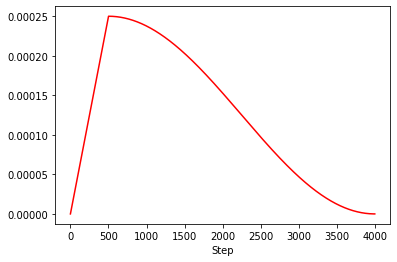

In [42]:
test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500)
lrs = []
for step_num in range(4000):
    lrs.append(test_schedule(float(step_num)).numpy())

plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.show()

In [43]:
pre_train_model = build_model_pre_train(config)

pre_train_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_tokens (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
segments (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
bert (BERT)                     ((None, 256), (None, 4485632     enc_tokens[0][0]                 
                                                                 segments[0][0]                   
__________________________________________________________________________________________________
pooled_nsp (PooledOutput)       (None, 2)            66304       bert[0][0]                 

In [44]:
epochs = 10
batch_size = 64

train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)

learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

pre_train_model.compile(
    loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss), 
    optimizer=optimizer, metrics={"nsp": "acc", "mlm": lm_acc})

train_steps: 143470


In [45]:
save_weights = tf.keras.callbacks.ModelCheckpoint(
    f'./models/bert_pre_train.hdf5',
    monitor="mlm_lm_acc", 
    verbose=1, 
    save_best_only=True, 
    mode="max", 
    save_freq="epoch", 
    save_weights_only=True)

In [46]:
history = pre_train_model.fit(
    pre_train_inputs, 
    pre_train_labels, 
    epochs=epochs, 
    batch_size=batch_size, 
    callbacks=[save_weights])

Epoch 1/10
14347/14347 [==============================] - 1889s 131ms/step - loss: 15.0275 - nsp_loss: 0.5377 - mlm_loss: 14.4898 - nsp_acc: 0.7364 - mlm_lm_acc: 0.1407

Epoch 00001: mlm_lm_acc improved from -inf to 0.14066, saving model to ./models/bert_pre_train.hdf5
Epoch 2/10
14347/14347 [==============================] - 1891s 132ms/step - loss: 10.7072 - nsp_loss: 0.5068 - mlm_loss: 10.2004 - nsp_acc: 0.7616 - mlm_lm_acc: 0.2644

Epoch 00002: mlm_lm_acc improved from 0.14066 to 0.26436, saving model to ./models/bert_pre_train.hdf5
Epoch 3/10
14347/14347 [==============================] - 1891s 132ms/step - loss: 9.9113 - nsp_loss: 0.5012 - mlm_loss: 9.4102 - nsp_acc: 0.7684 - mlm_lm_acc: 0.3006

Epoch 00003: mlm_lm_acc improved from 0.26436 to 0.30056, saving model to ./models/bert_pre_train.hdf5
Epoch 4/10
14347/14347 [==============================] - 1894s 132ms/step - loss: 9.5884 - nsp_loss: 0.4982 - mlm_loss: 9.0902 - nsp_acc: 0.7737 - mlm_lm_acc: 0.3152

Epoch 00004: mlm_l

### 7. 프로젝트 결과

학습된 모델과 학습과정을 시각화해 보세요. NSP와 MLM의 loss가 안정적으로 수렴하나요? 모델이 작기 때문에 loss가 잘 수렴하지 않을 수도 있어요.

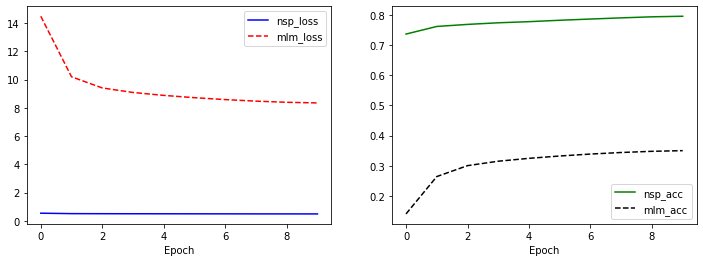

In [47]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['nsp_loss'], 'b-', label='nsp_loss')
plt.plot(history.history['mlm_loss'], 'r--', label='mlm_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['nsp_acc'], 'g-', label='nsp_acc')
plt.plot(history.history['mlm_lm_acc'], 'k--', label='mlm_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

### 회고

성능면) <br>
NSP모델은 epoch 횟수가 늘어도 nsp_loss값은 일정했다. 반면 mlm은 확실히 줄어들었다. 
acc는 NSP 모델, mlm 모델 모두 정확도가 늘었다.

모델build면) <br>
pretrain model을 (비록 노드를 많이 참고했지만) 처음으로 직접 손으로 짜봤는데.. 다시는 못할 것 같다, 너무 어렵다.. 하지만 pretrain 모델이 동작하는 원리를 학습하기엔 매우 유용했다. 내일, 내일 모레 고잉디퍼 챕터가 뭐가 나올진 모르지만, 메인퀘스트에 나올 수 있을 것 만큼 pretrain 모델도 굵직한 한 줄기로 꼭 활용할 줄 알아야겠다.